In [1]:
# Titanic Survival Prediction - End-to-End ML Pipeline
# Steps Covered:
# 1. Data Preprocessing
# 2. Model Building with Cross-Validation and Hyperparameter Tuning
# 3. Model Evaluation using Classification Metrics
# 4. Pipeline Integration
# Dataset: titanic.csv (Kaggle Titanic Dataset)

In [2]:
#Part 1: Data Preprocessing

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
# Load dataset
df = pd.read_csv('titanic.csv')

In [5]:
# Drop columns that won't help in prediction
df = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

In [6]:
# Separate features and target
X = df.drop("Survived", axis=1)
y = df["Survived"]

In [7]:
# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

In [8]:
# Define preprocessing steps
numeric_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
numeric_preprocessor

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [9]:
categorical_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
categorical_preprocessor

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [10]:
# Combine both preprocessors
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_preprocessor, num_cols),
    ("cat", categorical_preprocessor, cat_cols)
])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked'])])

In [11]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
#Part 2: Model Building

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [14]:
# Create pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [15]:
# Set up grid search parameters
param_grid = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [4, 6, 8],
    "classifier__min_samples_split": [2, 5]
}

In [16]:
# GridSearch with cross-validation
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [4, 6, 8],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy')

In [17]:
# Best model after hyperparameter tuning
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)

In [18]:
#Part 3: Evaluation

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

In [20]:
# Predict on test data
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

In [21]:
# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

In [22]:
# Display results
print("Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")

Evaluation Metrics:
Accuracy : 0.8156
Precision: 0.8361
Recall   : 0.6892
F1-Score : 0.7556
ROC-AUC  : 0.8899


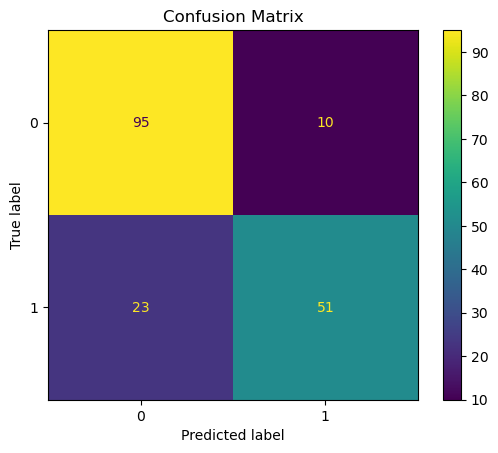

In [23]:
# Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

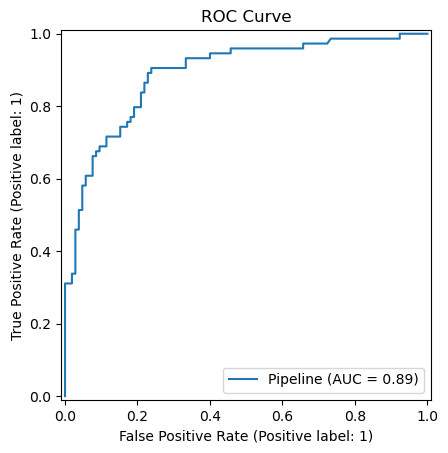

In [24]:
# Plot ROC curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

In [25]:
#Part 4: Pipeline Integration

In [26]:
import joblib

joblib.dump(best_model, "titanic_pipeline.pkl")
print("Saved full pipeline as titanic_pipeline.pkl")

Saved full pipeline as titanic_pipeline.pkl
